In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Cargar datos
data = pd.read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/RecomSystemsLectures/main/L07_sentimientos/data/Amazon.csv', index_col="Unnamed: 0")

# Visualizar las primeras filas del dataset
data.head()


,id,reviews.text,reviews.rating,reviews.text_esp
0,AVqVGWQDv8e3D1O-ldFr,This is a very nice tablet for my GF who has n...,5.0,Esta es una tableta muy agradable para mi novi...
1,AVqkIhwDv8e3D1O-lebb,Love this tablet. Easy to use. And price was r...,5.0,Me encanta esta tableta. Fácil de usar. Y el p...
2,AVphgVaX1cnluZ0-DR74,Affordable price awesome quality I love my Ama...,5.0,Precio asequible calidad increíble Me encanta ...
3,AVphgVaX1cnluZ0-DR74,I bought this after speaking with a sales rep ...,5.0,Compré esto después de hablar con un represent...
4,AVqVGWLKnnc1JgDc3jF1,Bought this tablet for my 2 &1/2 year old and ...,5.0,Compré esta tableta para mi hijo de 2 años y m...


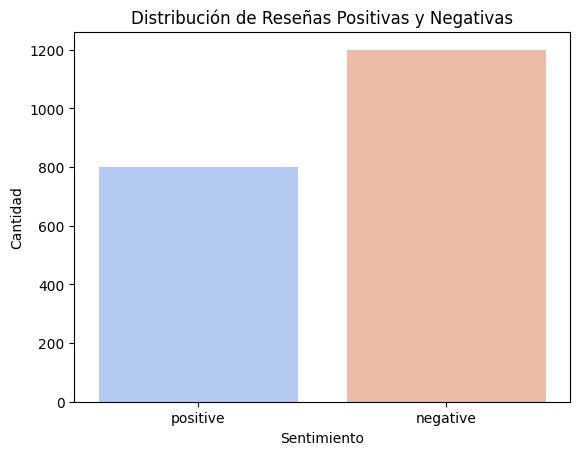

In [2]:
# Etiquetar sentimientos
data['sentiment'] = data['reviews.rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

# Graficar reseñas positivas y negativas
sns.countplot(x='sentiment', data=data, palette='coolwarm')
plt.title('Distribución de Reseñas Positivas y Negativas')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.show()


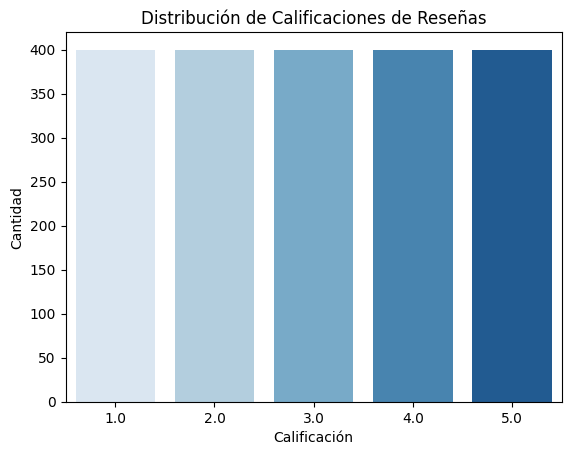

In [3]:
puntaje = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1}
sentimiento = {0: 'NEGATIVO', 1: 'POSITIVO'}

# Mapear puntaje y sentimiento
data['puntaje'] = data['reviews.rating'].map(puntaje)
data['sentimiento'] = data['puntaje'].map(sentimiento)

# Graficar distribución de calificaciones de reseñas
sns.countplot(x='reviews.rating', data=data, palette='Blues')
plt.title('Distribución de Calificaciones de Reseñas')
plt.xlabel('Calificación')
plt.ylabel('Cantidad')
plt.show()


In [4]:
!python -m spacy download es_core_news_sm


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.9 MB 8.3 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.9 MB 8.9 MB/s eta 0:00:02
     ------------- -------------------------- 4.5/12.9 MB 8.6 MB/s eta 0:00:01
     --------------------- ------------------ 6.8/12.9 MB 9.3 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.9 MB 9.4 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.9 MB 9.7 MB/s eta 0:00:01
     ---------------------------------------- 12.9/12.9 MB 9.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
import spacy
from num2words import num2words

# Filtrar columnas necesarias
data = data[['reviews.text_esp', 'reviews.rating']]

# Cargar modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

# Stop words adicionales
stop_words_adicionales = {"¡", "-", "—", "http", "<", ">"}
for palabra in stop_words_adicionales:
    nlp.Defaults.stop_words.add(palabra)

# Preprocesamiento del texto
def procesar_texto(texto):
    oraciones = texto.split('\n')
    total_oraciones = len(oraciones)
    oraciones_tokenizadas = []
    
    for oracion in oraciones:
        tokens = []
        doc = nlp(oracion)
        for token in doc:
            if token.is_digit:
                try:
                    numero = int(token.text)
                    palabra_letras = num2words(numero, lang='es')
                    tokens.append(palabra_letras)
                except ValueError:
                    pass
            else:
                lemma = token.text.lower()
                if lemma and lemma not in nlp.Defaults.stop_words:
                    tokens.append(lemma)
        oraciones_tokenizadas.append(" ".join(tokens))
    
    return total_oraciones, oraciones_tokenizadas

data['total_oraciones'], data['oraciones_tokenizadas'] = zip(*data['reviews.text_esp'].apply(procesar_texto))
data[['reviews.text_esp', 'oraciones_tokenizadas', 'reviews.rating']].head()


NameError: name 'procesar_texto' is not defined

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Cargar el modelo y el tokenizador solo una vez
modelo_nombre = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(modelo_nombre)
model = BertModel.from_pretrained(modelo_nombre)

#  Calcular embeddings para un chunk de datos
def calcular_embeddings(chunk):
    embeddings = []
    for texto in chunk['reviews.text_esp']:
        tokens = tokenizer(texto, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            output = model(**tokens)
            embedding = output.last_hidden_state.mean(dim=1).squeeze().numpy()
            embeddings.append(embedding)
    return pd.Series(embeddings)

num_threads = 4
data_chunks = np.array_split(data, num_threads)

# Ejecutar procesamiento en paralelo
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    embeddings_chunks = [chunk.reset_index(drop=True) for chunk in executor.map(calcular_embeddings, data_chunks)]

# Concatenar los embeddings resultantes y restablecer indice
data['embedding_resena'] = pd.concat(embeddings_chunks, ignore_index=True)
embeddings_df = pd.DataFrame(data['embedding_resena'].to_list())

# Mostrar la salida
data[['reviews.text_esp', 'embedding_resena', 'reviews.rating']].head()



Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,reviews.text_esp,embedding_resena,reviews.rating
0,Esta es una tableta muy agradable para mi novi...,"[-0.30398327, 0.12025499, -0.25350323, 0.02291...",5.0
1,Me encanta esta tableta. Fácil de usar. Y el p...,"[-0.060177866, -0.061638623, -0.39140293, -0.2...",5.0
2,Precio asequible calidad increíble Me encanta ...,"[0.103994936, -0.17487662, -0.47007528, -0.400...",5.0
3,Compré esto después de hablar con un represent...,"[-0.067099534, -0.009078686, -0.3586333, 0.403...",5.0
4,Compré esta tableta para mi hijo de 2 años y m...,"[-0.0013124432, -0.023810018, -0.3820344, 0.07...",5.0


In [ ]:
from sklearn.cluster import KMeans

# 3 clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajustar el modelo de clustering a los embeddings
kmeans.fit(embeddings_df)
etiquetas_clusters = kmeans.labels_

# Crear DataFrame con resultados de clustering
data_clusters = pd.DataFrame({
    'reseña': data['reviews.text_esp'],
    'oraciones_tokenizadas': data['oraciones_tokenizadas'],
    'rating': data['reviews.rating'],
    'cluster': etiquetas_clusters
})

# Guardar DataFrame en un archivo CSV
data_clusters.to_csv('reseñas_con_clusters.csv', index=False, encoding='utf-8')

# Mostrar las primeras filas del DataFrame
data_clusters.head()


,reseña,oraciones_tokenizadas,rating,cluster
0,Esta es una tableta muy agradable para mi novi...,[tableta agradable novia .],5.0,2
1,Me encanta esta tableta. Fácil de usar. Y el p...,[encanta tableta . fácil . precio correcto],5.0,0
2,Precio asequible calidad increíble Me encanta ...,[precio asequible calidad increíble encanta ta...,5.0,0
3,Compré esto después de hablar con un represent...,[compré hablar representante ventas tigertown ...,5.0,2
4,Compré esta tableta para mi hijo de 2 años y m...,[compré tableta hijo dos años perfecta . juego...,5.0,0


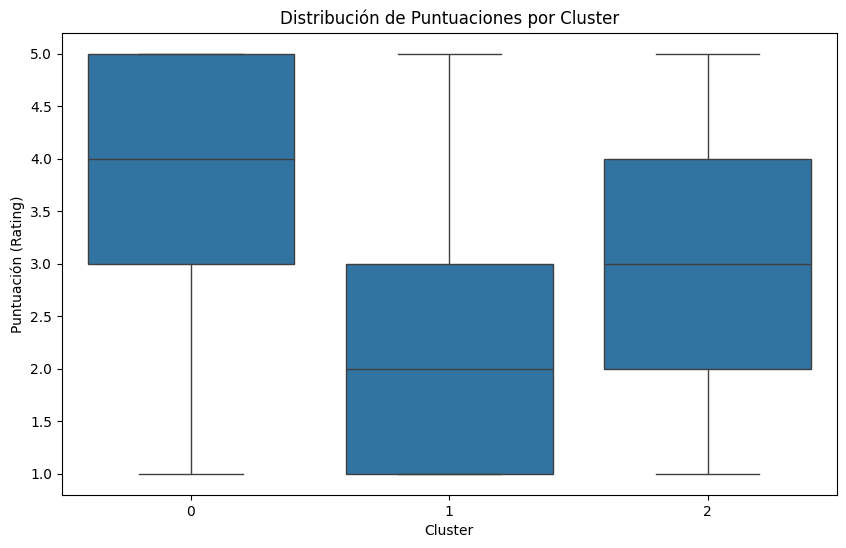

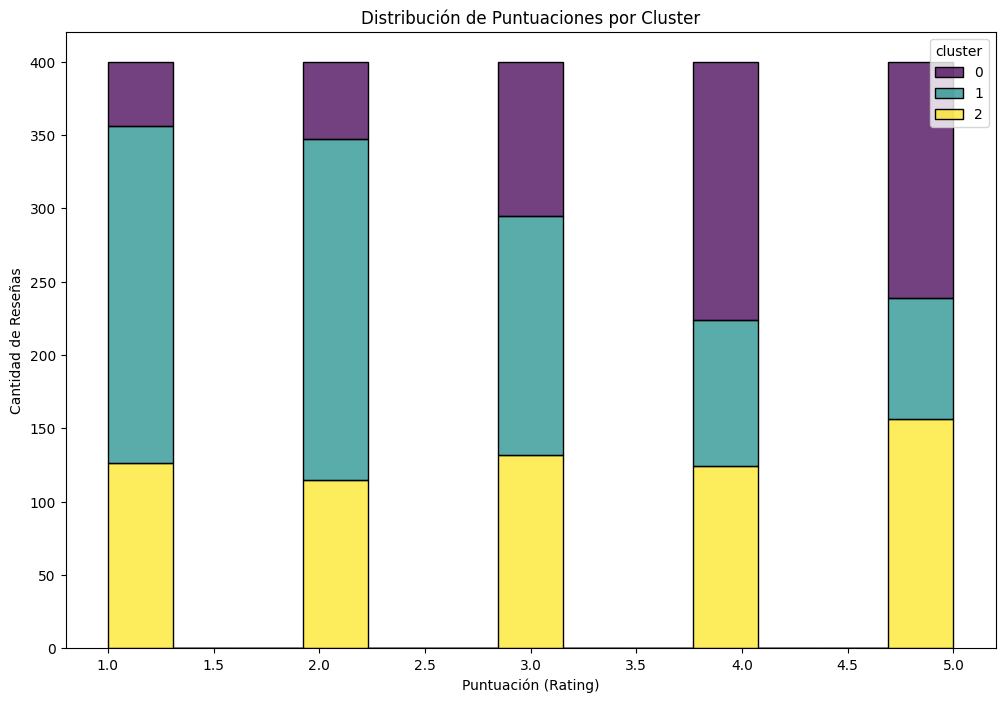

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot de puntuaciones en cada cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='rating', data=data_clusters)
plt.title("Distribución de Puntuaciones por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Puntuación (Rating)")
plt.show()

# Histograma de puntuaciones en cada cluster
plt.figure(figsize=(12, 8))
sns.histplot(data=data_clusters, x='rating', hue='cluster', multiple='stack', palette='viridis')
plt.title("Distribución de Puntuaciones por Cluster")
plt.xlabel("Puntuación (Rating)")
plt.ylabel("Cantidad de Reseñas")
plt.show()
